# XGBoost hyperparameter tuning

In [39]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
from math import sqrt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
import multiprocessing

import seaborn as sns 
import matplotlib.pyplot as plt 

In [4]:
data =  pd.read_csv('Dataset.csv', index_col= 0)
data.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [5]:
def fibo(n):
    cases = {
        "zero": 0,
        "one": 1,
        "two_or_more": 2
    }
    
    if n in cases:
        return cases[n]
    
    if n < 0:
        return "Error: n should be positive"
    elif n <= 1:
        return n
    else:
        a, b = 0, 1
        for _ in range(2, n + 1):
            a, b = b, a + b
        return b

In [6]:
data['stops'] = data['stops'].apply(fibo)

In [8]:
labelEncoder = LabelEncoder()
data_encoder = data

for e in data.columns:
    if data[e].dtype == 'object':
        labelEncoder.fit(list(data[e].values))
        data[e] = labelEncoder.transform(data[e].values)

In [9]:
y = data_encoder['price']
x = data_encoder.drop(['price','flight'], axis = 1)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, 
                                                    shuffle=True , 
                                                    stratify=None, 
                                                    test_size=0.20)

In [ ]:
model=XGBRegressor(random_state = 123)
model.fit(x_train, y_train) 

In [12]:
# predict X train
trainPredict = model.predict(x_train)

# predict X test  
testPredict = model.predict(x_test)

In [13]:
# R Squared 
testRsquared = metrics.r2_score(y_test, testPredict)
print(f'R-Squared : {testRsquared}')

# Mean Absolute Error
testMAE = metrics.mean_absolute_error(y_test, testPredict)
print(f'MAE : {testMAE}')

R-Squared : 0.9758307727469201
MAE : 2033.4526237788616


# RepeatedKFold

In [82]:
# Hyperparameters grid 
# ==============================================================================
param_grid = {'n_estimators'     : [ 100, 200],#, 500],
              'max_depth'        : [None, 1, 3, 5, 10, 20],
              'n_jobs'           : [-1, 1, 4, 5, 10],
              'subsample'        : [0.5, 1],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'booster'          : ['gbtree', 'gblinear'],
              'reg_alpha'        : [0.1, 10],
              'reg_lambda'       : [0.1, 10]
              } 

In [83]:

fit_params = {"early_stopping_rounds" : 5, 
              "eval_metric"           : "rmse", 
              "eval_set"              : [(x_test, y_test)],
              "verbose"               : 0
             }

In [ ]:
# Grid search (cv)
# ==============================================================================
grid = GridSearchCV(
        estimator  = XGBRegressor(
                        n_estimators = 100,
                        random_state = 123
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = x_train, y = y_train, **fit_params) 

In [85]:
# Hyperparameters by cross validation

print("----------------------------------------")
print("Best hyperparameters found (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

n_trees_included = len(grid.best_estimator_.get_booster().get_dump())
print(f"Number of trees: {n_trees_included}")

----------------------------------------
Best hyperparameters found (cv)
----------------------------------------
{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'n_jobs': -1, 'reg_alpha': 50, 'subsample': 1} : -3886.326733645892 neg_root_mean_squared_error
Number of trees: 176


In [14]:
model = XGBRegressor(random_state = 123,
    booster= 'gbtree',               
    n_estimators=200,
    learning_rate=0.1,
    max_depth=10,
    n_jobs=-1,
    subsample=1,  
    reg_alpha=10, 
    reg_lambda=0.1
) 
model = model.fit(x_train, y_train) # 10.9s

In [15]:
# predict X train
trainPredict = model.predict(x_train)

# predict X test  
testPredict = model.predict(x_test)

In [46]:
#Train Results  
print('R-squared:', r2_score(y_train, trainPredict))
print('MAE:', mean_absolute_error(y_train,trainPredict))
print('MSE:', mean_squared_error(y_train,trainPredict))
print('Median:', median_absolute_error(y_train,trainPredict))
print('RMSE:', sqrt(mean_squared_error(y_train,trainPredict)))

R-squared: 0.9918561684651603
MAE: 1097.5793362998443
MSE: 4203396.724263771
Median: 527.921875
RMSE: 2050.2187015691206


In [41]:
#Test Results
print('R-squared:', r2_score(y_test, testPredict))
print('MAE:', mean_absolute_error(y_test,testPredict))
print('MSE:', mean_squared_error(y_test,testPredict))
print('Median:', median_absolute_error(y_test,testPredict))
print('RMSE:', sqrt(mean_squared_error(y_test,testPredict)))

R-squared: 0.9867146520452392
MAE: 1341.0769582388332
MSE: 6793043.603934898
Median: 591.5517578125
RMSE: 2606.346792722507


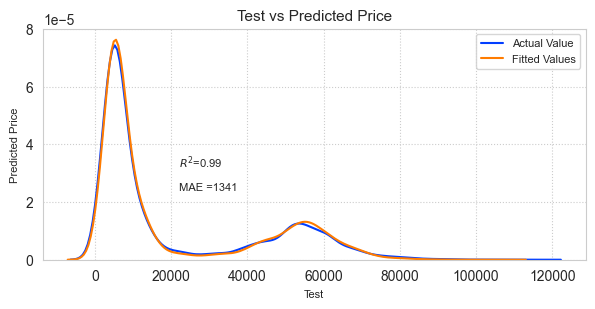

In [53]:

sns.set_style("whitegrid", {'grid.linestyle': ':'})
sns.set_palette("bright")
plt.figure(figsize=(7, 3))

ax = sns.kdeplot(y_test, label="Actual Value")
sns.kdeplot(testPredict, label="Fitted Values", ax=ax)

plt.title('Test vs Predicted Price', fontsize=11)
plt.xlabel('Test', fontsize=8)
plt.ylabel('Predicted Price', fontsize=8)

plt.text(0.25, 0.4, '$ R^{2} $=' + str(round(testRsquared, 2)), fontsize=8, transform=ax.transAxes)
plt.text(0.25, 0.3, 'MAE =' + str(round(testMAE)), fontsize=8, transform=ax.transAxes)

plt.legend(fontsize=8)
plt.show()

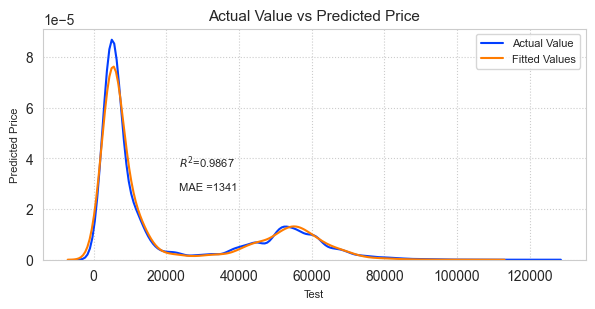

In [61]:
sns.set_style("whitegrid", {'grid.linestyle': ':'})
sns.set_palette("bright")
plt.figure(figsize=(7, 3))

ax = sns.kdeplot(y, label="Actual Value")
sns.kdeplot(testPredict, label="Fitted Values", ax=ax)

plt.title('Actual Value vs Predicted Price', fontsize=11)
plt.xlabel('Test', fontsize=8)
plt.ylabel('Predicted Price', fontsize=8)

plt.text(0.25, 0.4, '$ R^{2} $=' + str(round(testRsquared, 4)), fontsize=8, transform=ax.transAxes)
plt.text(0.25, 0.3, 'MAE =' + str(round(testMAE)), fontsize=8, transform=ax.transAxes)

plt.legend(fontsize=8)
plt.show()

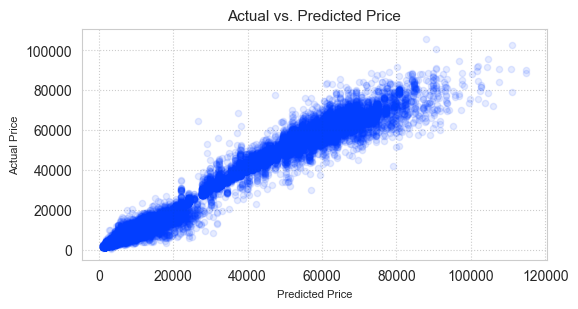

In [81]:
plt.figure(figsize=(6, 3))
plt.scatter(y_test,testPredict, alpha = 0.1, s = 20)
plt.title('Actual vs. Predicted Price', fontsize=11)
plt.xlabel('Predicted Price', fontsize=8)
plt.ylabel('Actual Price',fontsize=8)
plt.show()